# Computing MVBS based on time

For calculating MVBS based on time, when the desired temporal resolution is fine (~seconds), the xarray resample operation can be really slow. It is most likely a balance between the number of pings in each file and the number of pings that go into each temporal interval. 

In this notebook we use each file size as a chunk and try to do 5-min resample and see what happens. Note that the same operation is not possible with chunk=4000. The file size makes each chunk ~28700.

In [1]:
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
client = Client()

In [3]:
from dask.distributed import performance_report

## Load multiple data files

In [4]:
nc_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_raw/'
nc_files = sorted(glob.glob(nc_path+'*.nc'))   # sort to order by date in filename
nc_Sv_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_raw/'
nc_Sv_files = sorted(glob.glob(nc_Sv_path+'*_Sv.nc'))   # sort to order by date in filename

In [22]:
ds = xr.open_mfdataset(nc_Sv_files[:5], combine='by_coords')
ds

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 143564, range_bin: 1046)
Coordinates:
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-21T23:19:59.682000
Data variables:
    Sv         (frequency, ping_time, range_bin) float64 dask.array<chunksize=(3, 28718, 1046), meta=np.ndarray>
    range      (ping_time, frequency, range_bin) float64 dask.array<chunksize=(28718, 3, 1046), meta=np.ndarray>

In [23]:
ds.chunks

Frozen(SortedKeysDict({'frequency': (3,), 'ping_time': (28718, 28717, 28714, 28703, 28712), 'range_bin': (1046,)}))

In [24]:
ds.Sv.data

dask.array<concatenate, shape=(3, 143564, 1046), dtype=float64, chunksize=(3, 28718, 1046), chunktype=numpy.ndarray>

## Set MVBS params and output file path and filename

In [25]:
MVBS_range_bin_size = 5  # [m]

In [26]:
save_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_MVBS/'
MVBS_fname_from_Sv_time_prefix = (f'20150817-20151017_MVBS_time_from_Sv'
                                  f'_rangeBin{MVBS_range_bin_size}_')

In [27]:
MVBS_fname_from_Sv_time_prefix

'20150817-20151017_MVBS_time_from_Sv_rangeBin5_'

## Get various variables for MVBS calculation

Calculating sample thickness, which will be used to determine the number of range bins used for each MVBS tile.

In [28]:
with xr.open_dataset(nc_files[0], group="Beam") as ds_beam:
    with xr.open_dataset(nc_files[0], group="Environment") as ds_env:
        sample_thickness = ds_env.sound_speed_indicative * ds_beam.sample_interval / 2  # sample thickness
sample_thickness

<xarray.DataArray (frequency: 3)>
array([0.19121777, 0.19121777, 0.19121777], dtype=float32)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0

Set range bin (depth) and ping number sizes for each MVBS tile.

Adjust tile range bin size so that it is an integer multiple of the sample thickness.

In [29]:
# Adjust noise_est_range_bin_size because range_bin_size may be an inconvenient value
r_data_sz = ds['range_bin'].size   # dimension of range_bin in data file
num_r_per_tile = (np.round(MVBS_range_bin_size / sample_thickness).
                  astype(int)).values.max()  # num of range_bin per tile
MVBS_range_bin_size = (num_r_per_tile * sample_thickness).values

num_tile_range_bin = np.ceil(r_data_sz / num_r_per_tile).astype(int)

print(f'There are {num_r_per_tile} range bins in each MVBS tile.')
print(f'There are a total of {num_tile_range_bin} range_bin bins for each Sv tile.')

There are 26 range bins in each MVBS tile.
There are a total of 41 range_bin bins for each Sv tile.


Below are the bin edges we will use to group values along the `range_bin` dimension:

In [30]:
r_tile_bin_edge = np.arange(num_tile_range_bin+1) * num_r_per_tile - 1
r_tile_bin_edge

array([  -1,   25,   51,   77,  103,  129,  155,  181,  207,  233,  259,
        285,  311,  337,  363,  389,  415,  441,  467,  493,  519,  545,
        571,  597,  623,  649,  675,  701,  727,  753,  779,  805,  831,
        857,  883,  909,  935,  961,  987, 1013, 1039, 1065])

## MVBS computation

In [31]:
ds_linear = 10**(ds/10)  # convert to linear domain
ds_linear

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 143564, range_bin: 1046)
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-21T23:19:59.682000
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
Data variables:
    Sv         (frequency, ping_time, range_bin) float64 dask.array<chunksize=(3, 28718, 1046), meta=np.ndarray>
    range      (ping_time, frequency, range_bin) float64 dask.array<chunksize=(28718, 3, 1046), meta=np.ndarray>

### Based on time along ping_time

The coarsen operation can only be based on index, so to compute MVBS based on the actual timestamp, we will need to combined `resample` and `groupby_bins` along the `ping_time` and `range_bin` dimensions, respectively.

Let's do this by trying to produce MVBS with a cell size of 20 min x ~5 m.

In [32]:
ds_linear_time = ds_linear.resample(ping_time='5min',skipna=True).\
                 mean().dropna(dim='ping_time')
ds_linear_time

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 480, range_bin: 1046)
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-08-21T23:15:00
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
Data variables:
    Sv         (ping_time, frequency, range_bin) float64 dask.array<chunksize=(1, 3, 1046), meta=np.ndarray>
    range      (ping_time, frequency, range_bin) float64 dask.array<chunksize=(1, 3, 1046), meta=np.ndarray>

Let's check the ping time to make sure results of the resampling operation makes sens:

In [33]:
ds_linear_time['ping_time']

<xarray.DataArray 'ping_time' (ping_time: 480)>
array(['2015-08-17T00:00:00.000000000', '2015-08-17T00:05:00.000000000',
       '2015-08-17T00:10:00.000000000', ..., '2015-08-21T23:05:00.000000000',
       '2015-08-21T23:10:00.000000000', '2015-08-21T23:15:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-08-21T23:15:00

In [34]:
MVBS_time = 10*np.log10(  # convert back to log domain
    ds_linear_time.groupby_bins('range_bin',r_tile_bin_edge).mean())
MVBS_time = MVBS_time.rename({'Sv': 'MVBS'})
MVBS_time

<xarray.Dataset>
Dimensions:         (frequency: 3, ping_time: 480, range_bin_bins: 41)
Coordinates:
  * ping_time       (ping_time) datetime64[ns] 2015-08-17 ... 2015-08-21T23:15:00
  * frequency       (frequency) float32 120000.0 38000.0 200000.0
  * range_bin_bins  (range_bin_bins) object (-1, 25] (25, 51] ... (1039, 1065]
Data variables:
    MVBS            (range_bin_bins, ping_time, frequency) float64 dask.array<chunksize=(1, 1, 3), meta=np.ndarray>
    range           (range_bin_bins, ping_time, frequency) float64 dask.array<chunksize=(1, 1, 3), meta=np.ndarray>

In [35]:
MVBS_time['range'] = ('range_bin_bins',
                      np.arange(MVBS_time['range_bin_bins'].size)*np.unique(MVBS_range_bin_size))
MVBS_time.coords['range_bin'] = ('range_bin_bins',
                                 np.arange(MVBS_time['range_bin_bins'].size))
MVBS_time = MVBS_time.swap_dims({'range_bin_bins': 'range_bin'}).\
                      drop_vars('range_bin_bins')

In [36]:
MVBS_time

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 480, range_bin: 41)
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-08-21T23:15:00
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
Data variables:
    MVBS       (range_bin, ping_time, frequency) float64 dask.array<chunksize=(1, 1, 3), meta=np.ndarray>
    range      (range_bin) float64 0.0 4.972 9.943 14.91 ... 188.9 193.9 198.9

In [37]:
MVBS_time.to_netcdf(os.path.join(save_path,MVBS_fname_from_Sv_time))

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


## Compare MVBS based on ping number index and actual ping time

In [38]:
ds_mvbs_time = xr.open_dataset(os.path.join(save_path,MVBS_fname_from_Sv_time))
ds_mvbs_time

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 480, range_bin: 41)
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-08-21T23:15:00
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
Data variables:
    MVBS       (range_bin, ping_time, frequency) float64 ...
    range      (range_bin) float64 ...

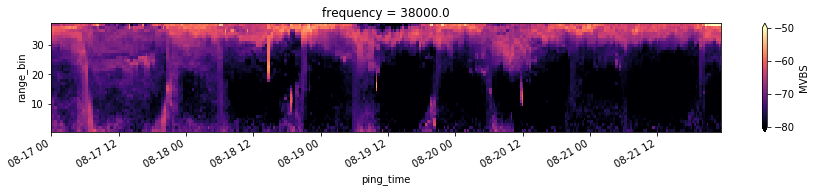

In [39]:
fig, ax = plt.subplots(figsize=(15,2))
ds_mvbs_time['MVBS'].sel(frequency=38000).isel(range_bin=slice(1,38)).\
    plot(ax=ax, x='ping_time',cmap='magma',vmin=-80,vmax=-50)
plt.show()

In [40]:
ds_mvbs_time['ping_time'].isel(ping_time=slice(0,5))

<xarray.DataArray 'ping_time' (ping_time: 5)>
array(['2015-08-17T00:00:00.000000000', '2015-08-17T00:05:00.000000000',
       '2015-08-17T00:10:00.000000000', '2015-08-17T00:15:00.000000000',
       '2015-08-17T01:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-08-17T01:00:00